In [1]:
%matplotlib inline

import os
import pandas as pd
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from collections import defaultdict
import itertools
import math

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.mplot3d import Axes3D

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA, KernelPCA

import torch
from torch.utils.data import DataLoader

from src.datasets.manifolds import SwissRoll, SCurve, Spheres
from src.evaluation.utils import get_space

#from src.datasets.splitting import split_dataset

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Load dataset
batch_size = 64
train = True
datasets_ = {'SwissRoll': SwissRoll(train=train), 'SCurve': SCurve(train=train),
             'Spheres': Spheres(train=train)}
datasets={}
for dataset in datasets_.keys():
    if dataset not in datasets.keys():
        dataloader = DataLoader(datasets_[dataset], batch_size=batch_size, shuffle=False,
            pin_memory=True, drop_last=True)
        data_space, labels = get_space(None, dataloader, mode='data')
        datasets[dataset] = {
            'data_space': data_space,
            'labels': labels,
            'dataloader': dataloader
        }


In [4]:
# Load sacred runs
experiments = defaultdict(dict) 
def load_sacred_run(d):
    dataset, method = d.split('/')[-2:]
    dataset = dataset.split('.')[-1]
    method = method.split('.')[-1]
    method, repetition = method.split('_')
    print(dataset, method, repetition)
    model_path = os.path.join(d, 'model.pth')
    model = torch.load(model_path)
    latent = get_space(model, datasets[dataset]['dataloader'], mode='latent')[0]
    return {'method': method, 'dataset': dataset, 'latents': latent, 'repetition': repetition}
    
# Make list of dictionaries containing run information
runs = [load_sacred_run(os.path.dirname(f)) 
        for f in glob.glob('../exp_runs/train_model/dimensionality_reduction/**/run.json', recursive=True)
        if not '/1/' in f]  # Skip unfinished runs

Spheres VAETopoRegSorted rep4
Spheres VAETopoRegSorted rep3
Spheres VAETopoRegEdgeSymmetric rep2
Spheres VAETopoReg rep3
Spheres VAETopoRegEdgeSymmetric rep4
Spheres VAETopoRegEdgeSymmetric rep3
Spheres VAETopoReg rep4
Spheres Vanilla rep4
Spheres TopoRegEdgeSymmetric rep2
Spheres Vanilla rep2
Spheres TopoRegEdgeSymmetric rep3
Spheres TopoReg-cycles rep3
Spheres TopoReg-cycles rep2
Spheres TopoReg rep2
Spheres TopoRegSorted rep1
Spheres TopoReg rep3
Spheres TopoReg rep4
Spheres TopoRegEdgeSymmetric-cycles rep4
SwissRoll PCA


NameError: name 'n_components' is not defined

In [5]:
# Run competitor methods
competitior_methods = [PCA(n_components=2, random_state=42), TSNE(n_components=2, random_state=42)]
def run_competitor_on_dataset(dataset, method, repetition):
    data = datasets[dataset]['data_space']
    method_name = method.__name__
    print(dataset, method_name)
    m = method(n_components=2, random_state=seed)
    latent = m.fit_transform(data)
    return {'method': method_name, 'dataset': dataset, 'latents': latent, 'repetition': repetition}
    
competitor_methods = [PCA, TSNE]
competitor_runs = [run_competitor_on_dataset(dataset, method) for dataset, method
                    in itertools.product(datasets_.keys(), competitor_methods, ['rep1', 'rep2', 'rep3', 'rep4'])]

# Combine sacred runs and competitors into one dataframe
all_runs = pd.DataFrame(runs + competitor_runs)

SwissRoll PCA
SwissRoll TSNE
SCurve PCA
SCurve TSNE
Spheres PCA
Spheres TSNE


In [31]:
def plotting(transformed, all_labels, title):
    plt.scatter(transformed[:, 0], transformed[:, 1], c=all_labels, cmap=plt.cm.Spectral, s=2., alpha=0.5)
    plt.title(title)

def plot_all(dataset_name, latent_data):
    fig = plt.figure(1)
    n_methods = len(latent_data)
    n_cols = 3
    n_rows = math.ceil(n_methods + 1) / n_cols
    ax = fig.add_subplot(n_rows, n_cols, 1, projection="3d")
    
    # Get data space and labels from datasets dictionary
    X = datasets[dataset_name]['data_space']
    labels = datasets[dataset_name]['labels']
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap=plt.cm.Spectral, s=2., alpha=0.5)

    plt.xticks([]), plt.yticks([])
    myfontsize = 18
    plt.title(dataset_name, fontsize=myfontsize)
    ax.set_xlabel('x', fontsize=myfontsize)
    ax.set_ylabel('y', fontsize=myfontsize)
    ax.set_zlabel('z', fontsize=myfontsize)
    fig.set_size_inches(n_cols*4, n_rows*4)
    ax.view_init(15, 290) # rotation of the 3D plot
    # plt.show()
    
    subplot_count = 2
    for index, values in latent_data.iterrows():
        #add subplots for latent spaces:
        method = values['method'] + '_' + str(values['repetition'])
        latents = values['latents']
        ax = fig.add_subplot(n_rows, n_cols, subplot_count)
        plotting(latents, labels, f'{method}')
        subplot_count += 1

SwissRoll (5376, 2) (5376,)
SwissRoll (5376, 2) (5376,)


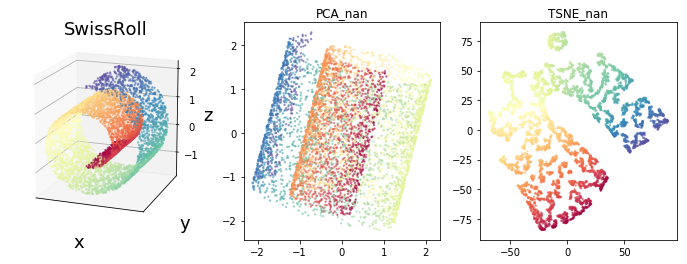

SCurve (5376, 2) (5376,)
SCurve (5376, 2) (5376,)


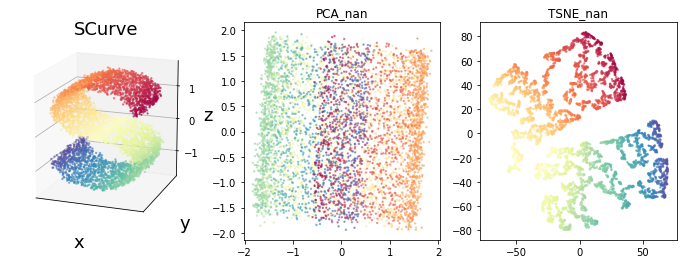

Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)
Spheres (17984, 2) (17984,)


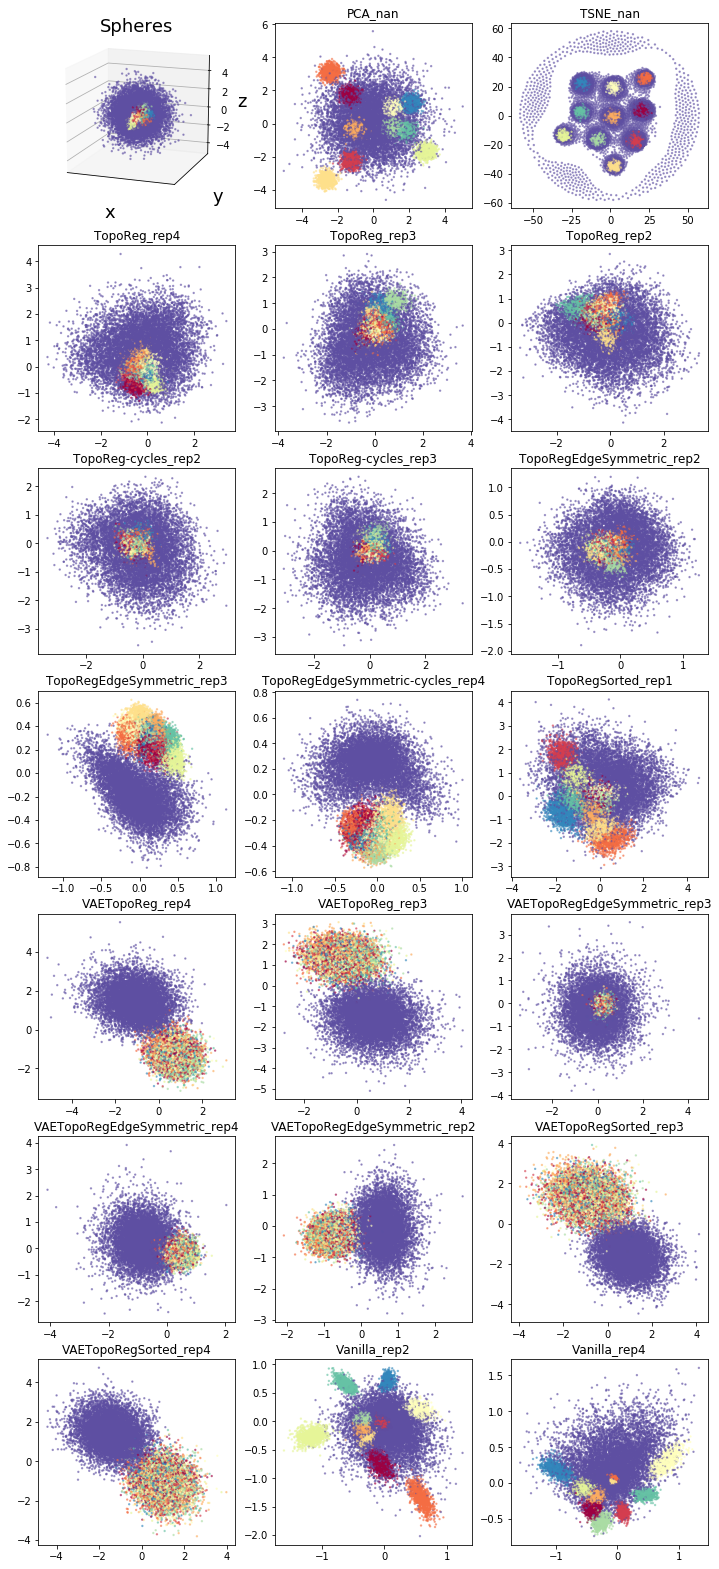

In [38]:
all_runs = all_runs.sort_values('method')
for dataset in datasets_.keys():
    plot_all(dataset, all_runs[all_runs['dataset'] == dataset])
    plt.show()

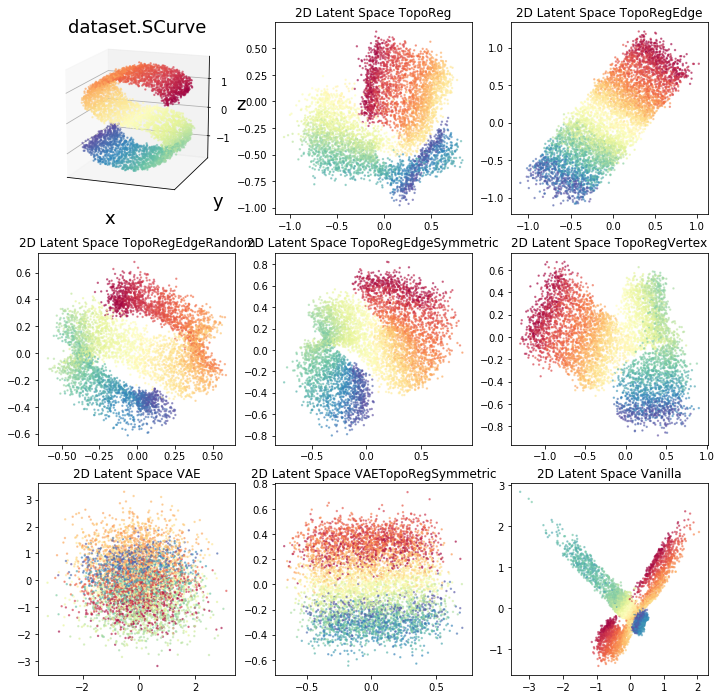

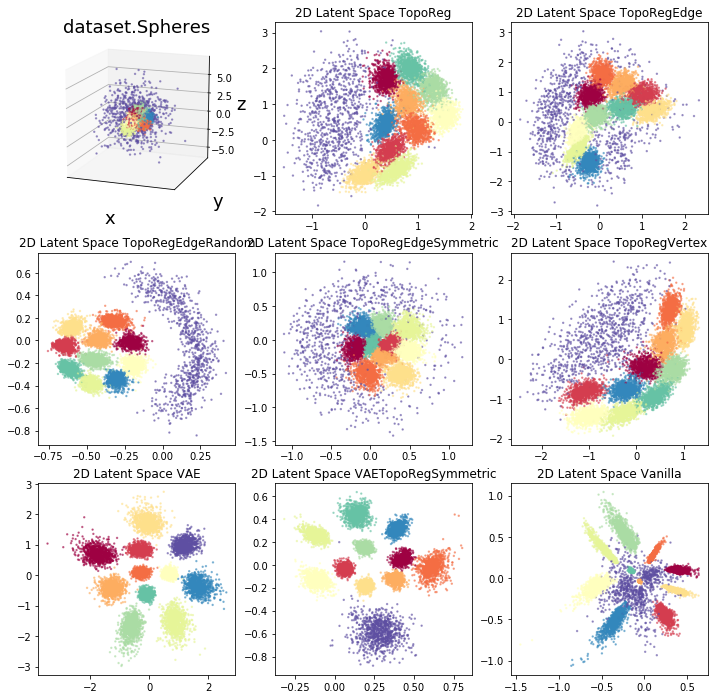

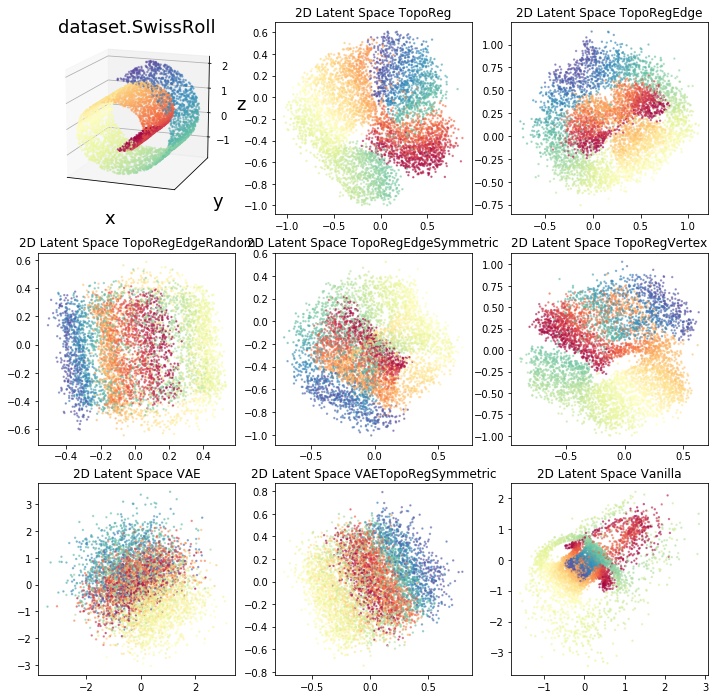

<Figure size 432x288 with 0 Axes>

In [11]:
%matplotlib inline

dataset= 'dataset.SCurve' #'swissroll' #'scurve' #'spheres'
for dataset in experiments.keys():

    X = experiments[dataset]['data_space']
    labels = experiments[dataset]['model.Vanilla']['labels']

    methods = []
    all_Z = []
    for key, value in experiments[dataset].items():
        if key.startswith('model'):
            methods.append(key)
            all_Z.append(value['latent'])
    plott_all(dataset, X, labels, methods, all_Z)
    plt.show()
    plt.savefig(f'{dataset}.png', dpi=200)


#Z2 = experiments[dataset][methods[4]]['latent']


# plt.savefig(f'200_epochs_{dataset}_train.png')